# **Çağdaş Güven 2738938**

# **ME 536**

### Find and count characters and their elements in strings
Check if you can see the hidden ***SVD flavor*** somewhere in the requirements!

In [ ]:
# only importing from following libraries are allowed. You can add more imports from them, but no new libraries here
from skimage import io
from skimage.filters import threshold_otsu as otsu
import numpy as np
from scipy.linalg import orth
from scipy.spatial import distance_matrix
from numpy.linalg import matrix_rank as rank
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans # just for demo purposes, you can import more if needed...

# also import the matrix printing function
!rm bug_numpy_utils.py 2> dump.me ## change these to ! when uploading the file
!wget https://raw.githubusercontent.com/bugrakoku/bug_python_utils/main/bug_numpy_utils.py  ## change these to ! when uploading the file
from bug_numpy_utils import CData as CMe
from bug_numpy_utils import GenerateDataforImage as GenImMat
from bug_numpy_utils import text2mat

--2024-12-06 18:04:11--  https://raw.githubusercontent.com/bugrakoku/bug_python_utils/main/bug_numpy_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18456 (18K) [text/plain]
Saving to: ‘bug_numpy_utils.py’

bug_numpy_utils.py  100%[===================>]  18.02K  --.-KB/s    in 0.005s  

2024-12-06 18:04:11 (3.26 MB/s) - ‘bug_numpy_utils.py’ saved [18456/18456]



# Intro to Basics: Assignment has not started yet!
This is the warm up

## Generate and plot reference text
Generate data matrix from a string.

Columns of this matrix are data points, which when plotted is read as the given string.  

Using pyplot display the data points to make sure that they are readable.  

The problem is given in 2D below, play with the ```NoiseLevel``` and observe how data points mere into each other.

In [2]:
# this is a support function to see the result of clustering better

def ColorizeChars(M, Mnum = [], Title='some string', figSize = (9, 3),  aspectR = 2):
    Indicies = np.hstack((np.array([0]), np.cumsum(Mnum)))
    fig, ax = plt.subplots(figsize= figSize) # Increased figure size
    # absence of Mnum is that we do not want to colorize the plot
    if Mnum is None or Mnum is [] or len(Mnum) == 0:
        ax.plot(M[0,:],M[1,:], '*')
    else:
        for i, uLim in enumerate(Indicies):
            if i < len(Indicies)-1:
                X = M[0, uLim:Indicies[i+1]]
                Y = M[1, uLim:Indicies[i+1]]
                #plt.plot(X,Y, '*')
                ax.plot(X,Y, '*')
    ax.set_aspect(aspectR) # Set the aspect ratio to aspectR:1
    ax.set_title(Title)
    plt.show()

Shape of T1 = (3, 2062), where letters of "hello clustering" has [166, 153, 128, 128, 148, 119, 128, 141, 137, 119, 153, 95, 124, 142, 181] data points in each corresponding letter


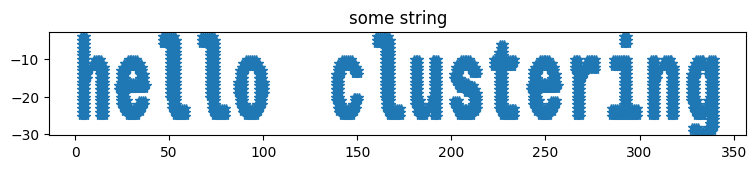

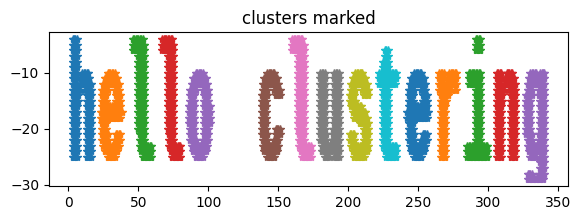

In [3]:
S1 = 'hello clustering'
T1, T1num = text2mat(S1)

# just that we get to understand ```text2mat``` function let's print the output of the function
print(f'Shape of T1 = {T1.shape}, where letters of "{S1}" has {T1num} data points in each corresponding letter')

NoiseLevel = 0.0

T1 += NoiseLevel * np.random.randn(*T1.shape)


ColorizeChars(T1) # just plot the data as a single chunk
ColorizeChars(T1, T1num, Title='clusters marked', figSize=(7,2), aspectR=4) # call this function anyway you like

### WARNING: Testing conditions is not Vanilla
Note that data matrix that will be sent might slightly be manipulated after it is generated with ```text2mat```, way beyond adding noise.  
Check out the following to give you an idea.

Note that when data matrix is shuffled, color printing makes no sense, because the columns are no more sorted, hence values returned by text2mat does not make sense.  


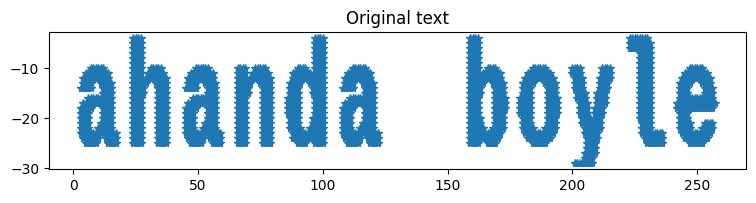

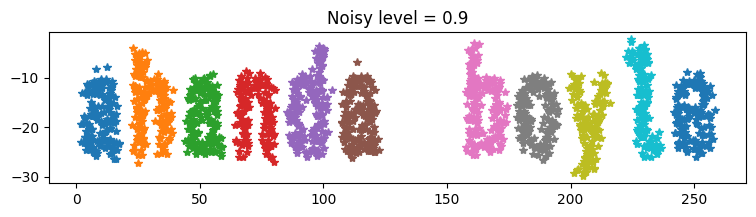

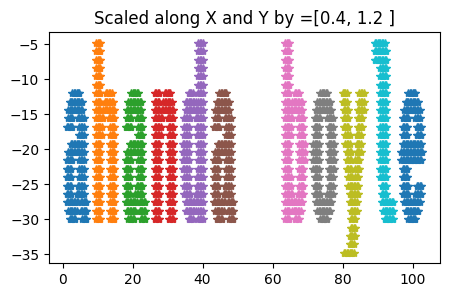

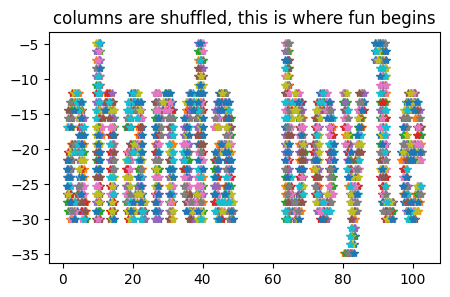

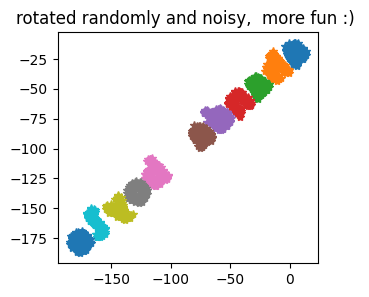

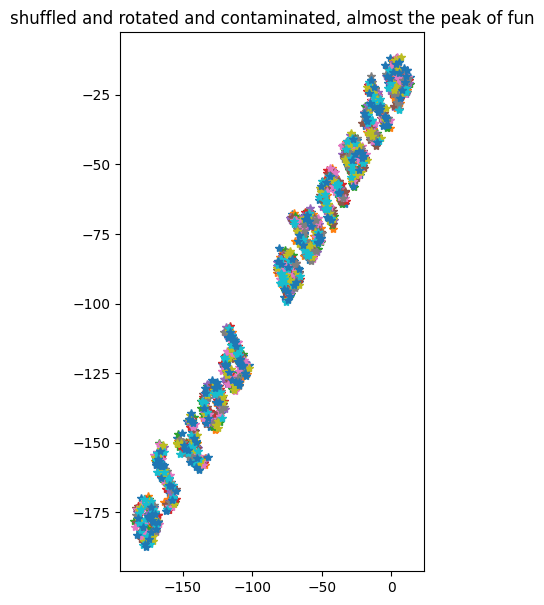

In [4]:
# CELL 1
Stest = 'ahanda boyle'
Ttest, Tnum = text2mat(Stest)
noiseLevel = 0.9

#'''
# original text
V1 = Ttest[0:2, :]
ColorizeChars(V1, Title='Original text')
#'''

#'''
# contaminated ... play with noise levels
V2 = V1 + noiseLevel * np.random.randn(*V1.shape)
ColorizeChars(V2, Tnum, Title=f'Noisy level = {noiseLevel}')
#'''

#'''
# extended or shrung along X-Y axis
V3 = np.copy(V1)
Xscale = 0.4
Yscale = 1.2
V3[0,:] *= Xscale
V3[1,:] *= Yscale
ColorizeChars(V3, Tnum, Title=f'Scaled along X and Y by =[{Xscale}, {Yscale} ]')
#'''

#'''
V4 = np.copy(V3)
V4 = V4[:, np.random.permutation(V4.shape[1])]
ColorizeChars(V4, Tnum, Title='columns are shuffled, this is where fun begins')
#'''

#'''
V5 = orth(np.random.rand(2,2)) @ V2
ColorizeChars(V5, Tnum, Title='rotated randomly and noisy,  more fun :) ', aspectR=1)
#'''


#'''
V6 = V5[:, np.random.permutation(V5.shape[1])]
ColorizeChars(V6, Tnum, Title='shuffled and rotated and contaminated, almost the peak of fun', figSize=(7,7))
#'''

# Assignment starts here
Read the following cells carefully and respond by filling in the code and text cells. Your explanations brief yet clear.

This assignment will hopefully make you better in clustering simple cases :)  
For harder cases, we will talk about artificial neural networks...

## Let's start with a show case
Note that ```text2mat``` function returns a data matrix and a list.  
Also note that the data matrix is sorted, so that the first groups of points belong to the first letter, second group to the second letter and so on.  
The list contains the number of points in each groups that correspond to the letters in the text that is sent to the function.

So your objective indeed is to recover clusters, sort them, so that when we print, it plot them using what is returned from your function, it plots properly.  

However, note that your sorting algorithm is not necessarily expected to find the order of clusters (i.e. letters), it is possible that you read the string from the end to beginning. By running the following you will see that the text might even be mirrorred. Under any circumstance, you should be able to find the alignment of the text, it does not matter wheter it is backwards or mirrorred, cluster it and return the sorted matrix along with the number of elements in each cluster, similar to what ```text2mat``` does. When we plot it using ```ColorizeChars``` it should look meaningful.

In other words, your element count list should either be similar to what text2sum returns or to the inverse of the list.  

Run the following cell for different noise levels and observe the changes.


## Clustering time:
Using any approach you like sort points in the given data matrix.
You can use hence import other sub-libraries in already imported libraries above.  
No new libraries...

Objective is to see if you can find letters indiviually.  
In other words, after we shuffle everything, objective is to check if you can

### Implemet the sorting function: i.e. ```SortPoints()```
If you would like to seperate this function into smaller other functions, write them in the support functions cell

In [5]:
# support functions goes in here so that I run them before SortPoints()
# write as many as needed
#



In [ ]:
# def SortPoints(M, K = -1):
#     '''
#     Columns of M are the data points
#     K is the number of clusters, if K = -1, this function is to find the number of clusters!

#     returns Ms, MsNum
#     Ms: the column sorted version of M, similar to what is given by text2mat before shuffle
#     MsNum: element count list --> the number of points in each cluster, similar to what text2mat returns
#     Note that len(MsNum) = number of letters in the original string
#     '''
#     # fill in the function so that...
#     Ms = None
#     MsNum = []


#     Ms, MsNum

In [23]:
def SortPoints(M, K=-1):
    """
    Sorts the points in M into clusters and arranges them meaningfully.
    
    Args:
        M (numpy.ndarray): Input data matrix of shape (D, N), where D is the dimension (2 or 3).
        K (int): Optional number of clusters. If not provided or -1, the function infers K.
    
    Returns:
        R (numpy.ndarray): Sorted matrix of points grouped by cluster.
        Rsum (list): List containing the number of points in each cluster.
    """
    # Step 1: Infer the number of clusters if K is not provided
    if K == -1:
        # Estimate K based on variations in X-coordinates (heuristic)
        unique_x = np.unique(M[0, :])
        K = len(unique_x)  # Approximate clusters based on unique X-coordinate variations
        print(f"Inferred number of clusters: {K}")

    # Step 2: Perform clustering (e.g., k-means)
    kmeans = KMeans(n_clusters=K, random_state=0).fit(M.T)
    labels = kmeans.labels_

    # Step 3: Sort clusters by centroid X-coordinates
    centroids = kmeans.cluster_centers_
    sorted_indices = np.argsort(centroids[:, 0])  # Sort by X-coordinate of centroids

    # Step 4: Group points by sorted clusters
    R = []
    Rsum = []
    for idx in sorted_indices:
        cluster_points = M[:, labels == idx]
        R.append(cluster_points)
        Rsum.append(cluster_points.shape[1])

    # Step 5: Combine sorted clusters into one matrix
    R = np.hstack(R)

    return R, Rsum

### Let's test the sorting function

If you have implemented ```SortPints``` properly, following should work.
I will only call ```SortPints``` to test your work.


Inferred number of clusters: 117


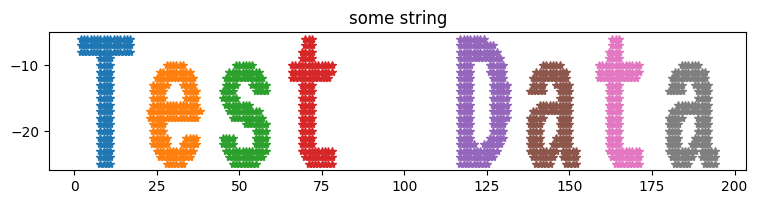

In [32]:
# let's generate test data
St = 'Test Data'
Tt, Ttsum = text2mat(St)
#in my case I will generate variations of Tt as I did above but for simplicty here I will stick with Tt

#I will run one of the following
R, Rsum = SortPoints(Tt) # case when k- number of clusters is given -
# also check for fun what happens when k is given to be something different then the correct value

R, Rsum = SortPoints(Tt, len(Ttsum)) # case when it is not given

# finally see the result
ColorizeChars(R, Rsum)


Inferred number of clusters: 117


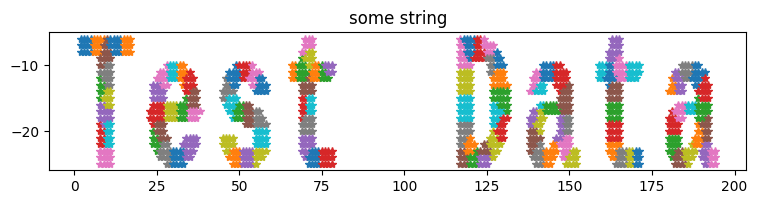

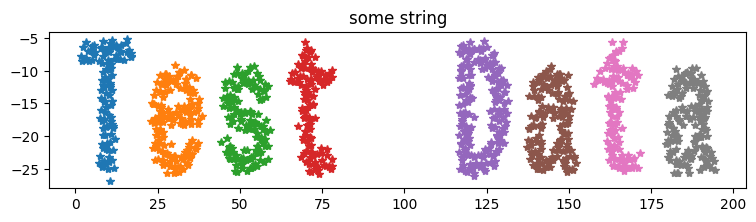

In [52]:
# Add mirroring
Tt[0, :] = -Tt[0, :]  # Mirror X-axis
R, Rsum = SortPoints(Tt)
ColorizeChars(R, Rsum)

# Add noise
noise = np.random.randn(*Tt.shape) * 0.5
Tt_noisy = Tt + noise
R, Rsum = SortPoints(Tt_noisy, len(Ttsum))
ColorizeChars(R, Rsum)


Test Case 1: Simple Clustered Data
Inferred number of clusters: 44


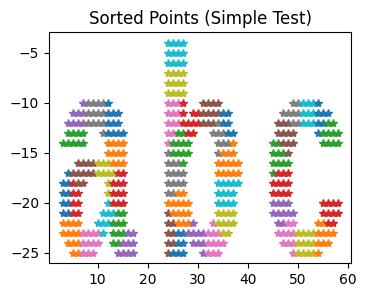

Test Case 2: Shuffled Data
Inferred number of clusters: 44


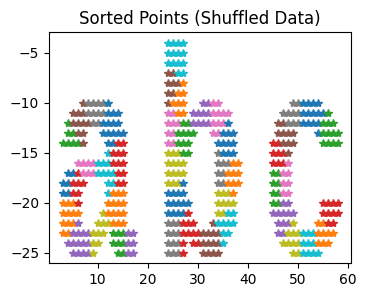

Test Case 3: Mirrored Data
Inferred number of clusters: 44


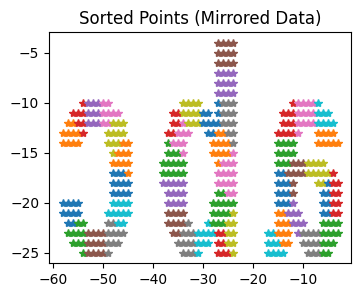

Test Case 4: Noisy Data
Inferred number of clusters: 451


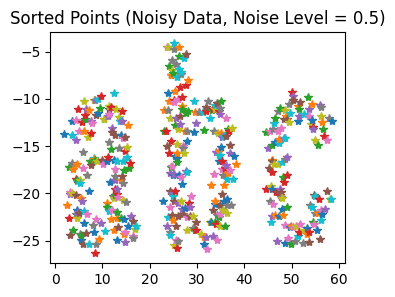

Test Case 5: Incorrect Number of Clusters


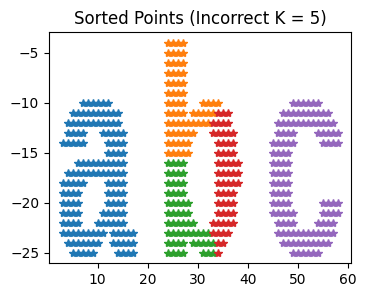

Test Case 6: Overlapping Letters
Inferred number of clusters: 451


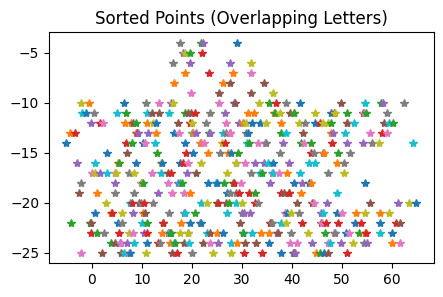

Test Case 7: Sparse Data
Inferred number of clusters: 43


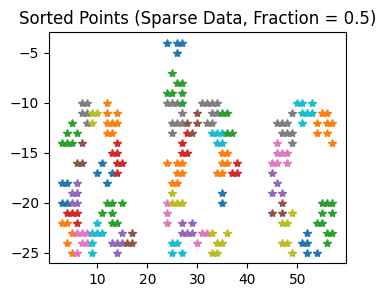

Test Case 8: Combination of Shuffling, Noise, and Mirroring
Inferred number of clusters: 451


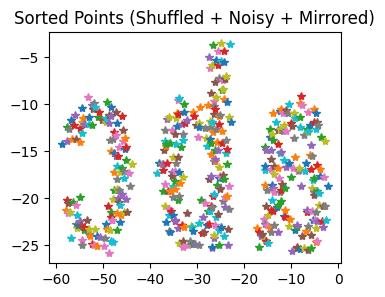

In [53]:
# Generate base test data
Stest = 'abc'
Ttest, Tnum = text2mat(Stest)
noiseLevel = 0.5  # Noise level for relevant tests
fraction = 0.5    # Fraction for sparse data

# 1. Simple Clustered Data
print("Test Case 1: Simple Clustered Data")
R, Rsum = SortPoints(Ttest)
ColorizeChars(R, Rsum, Title='Sorted Points (Simple Test)')

# 2. Shuffled Data
print("Test Case 2: Shuffled Data")
Tshuffled = Ttest[:, np.random.permutation(Ttest.shape[1])]
R, Rsum = SortPoints(Tshuffled)
ColorizeChars(R, Rsum, Title='Sorted Points (Shuffled Data)')

# 3. Mirrored Data
print("Test Case 3: Mirrored Data")
Tmirrored = np.copy(Ttest)
Tmirrored[0, :] = -Tmirrored[0, :]  # Mirror X-coordinates
R, Rsum = SortPoints(Tmirrored)
ColorizeChars(R, Rsum, Title='Sorted Points (Mirrored Data)')

# 4. Noisy Data
print("Test Case 4: Noisy Data")
Tnoisy = Ttest + noiseLevel * np.random.randn(*Ttest.shape)
R, Rsum = SortPoints(Tnoisy)
ColorizeChars(R, Rsum, Title=f'Sorted Points (Noisy Data, Noise Level = {noiseLevel})')

# 5. Incorrect Number of Clusters
print("Test Case 5: Incorrect Number of Clusters")
incorrect_K = len(Tnum) + 2  # More clusters than letters
R, Rsum = SortPoints(Ttest, incorrect_K)
ColorizeChars(R, Rsum, Title=f'Sorted Points (Incorrect K = {incorrect_K})')

# 6. Overlapping Letters
print("Test Case 6: Overlapping Letters")
Toverlap = np.copy(Ttest)
Toverlap[0, :] += np.random.uniform(-10, 10, size=Ttest.shape[1])
R, Rsum = SortPoints(Toverlap)
ColorizeChars(R, Rsum, Title='Sorted Points (Overlapping Letters)')

# 7. Sparse Data
print("Test Case 7: Sparse Data")
indices = np.random.choice(Ttest.shape[1], int(Ttest.shape[1] * fraction), replace=False)
Tsparse = Ttest[:, indices]
R, Rsum = SortPoints(Tsparse)
ColorizeChars(R, Rsum, Title=f'Sorted Points (Sparse Data, Fraction = {fraction})')

# 8. Combination: Shuffled + Noisy + Mirrored
print("Test Case 8: Combination of Shuffling, Noise, and Mirroring")
Tcombo = np.copy(Ttest)
Tcombo[0, :] = -Tcombo[0, :]  # Mirror
Tcombo = Tcombo + noiseLevel * np.random.randn(*Tcombo.shape)  # Add noise
Tcombo = Tcombo[:, np.random.permutation(Tcombo.shape[1])]  # Shuffle
R, Rsum = SortPoints(Tcombo)
ColorizeChars(R, Rsum, Title='Sorted Points (Shuffled + Noisy + Mirrored)')
